In [22]:
DATASET = 'CIFAR10' # choose dataset (CIFAR10, CIFAR100-20, or STL10)

In [23]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(), # load data as pytorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize/scale the images
])

# each set is loaded a bit differently
def load(dataset):
    if dataset == 'CIFAR10':
        trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform)
        testset  = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform)
        return trainset, testset
    elif dataset == 'CIFAR100-20':
        trainset = datasets.CIFAR100(root='./data/cifar100', train=True, download=True, transform=transform)
        testset  = datasets.CIFAR100(root='./data/cifar100', train=False, download=True, transform=transform)
        return trainset, testset
    elif dataset == 'STL10':
        # note the use of split='train' here instead of train=True
        trainset = datasets.STL10(root='./data/stl10', split='train', download=True, transform=transform)
        testset  = datasets.STL10(root='./data/stl10', split='test', download=True, transform=transform)
        return trainset, testset

trainset, testset = load(DATASET)
classes = trainset.classes # grab an array of classnames

# wrap in a dataloader -- for use in the CNN
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


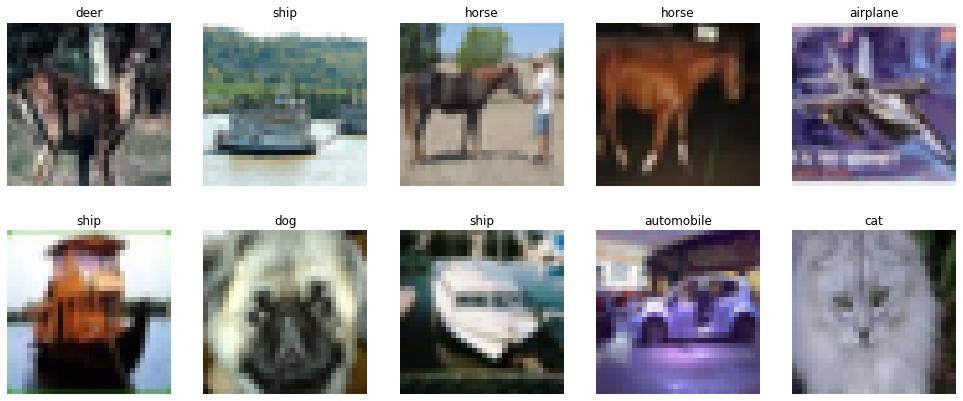

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# quick function to un-normalize and transpose images before graphing
def imshow(img):
    img = img / 2 + 0.5 # un-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

figure = plt.figure(figsize=(17, 7))
for i in range(1, 11):
    figure.add_subplot(2, 5, i)
    image, label = next(iter(trainloader))
    plt.title(classes[label[0].item()])
    plt.axis("off")
    img = image[0].squeeze()
    label = label[0]
    imshow(make_grid(img))
plt.show()

In [25]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

output_size = 100 if DATASET == 'CIFAR100-20' else 10

# stl10
class STL10(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(3*96*96, 1024), nn.ReLU(),
            nn.Linear(1024, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, output_size)
        )
        
    def forward(self, x):
        x = x.view(-1, 3*96*96)
        x = self.network(x)
        return x

# cifar10 and cifar 100-20
class CIFAR(nn.Module):
    def __init__(self):
        super(CIFAR, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5) # transpose for matrix multiplication
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = STL10() if DATASET == 'STL10' else CIFAR()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [26]:
from torch.autograd import Variable 

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data 
        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0
print('finished training')

[1,  2000] loss: 2.206
[1,  4000] loss: 1.902
[1,  6000] loss: 1.767
[1,  8000] loss: 1.672
[1, 10000] loss: 1.606
[1, 12000] loss: 1.555
[2,  2000] loss: 1.494
[2,  4000] loss: 1.456
[2,  6000] loss: 1.422
[2,  8000] loss: 1.411
[2, 10000] loss: 1.391
[2, 12000] loss: 1.373
finished training


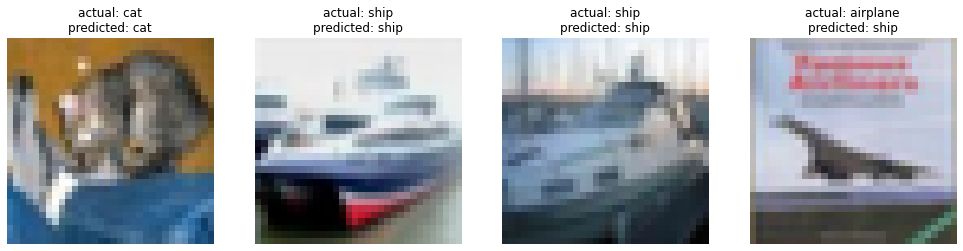

In [27]:
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.utils import make_grid

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)

# plot some images and show actual vs predicted label
figure = plt.figure(figsize=(17, 7))
for img, i in zip(images, [0, 1, 2, 3]):
    figure.add_subplot(1, 4, i+1)
    plt.title('actual: ' + classes[labels[i]] + '\npredicted: ' + classes[predicted[i]])
    plt.axis("off")
    imshow(make_grid(img))
plt.show()

In [28]:
import numpy as np

# grab the labels from the testset
y_test = testloader.dataset.labels if DATASET == 'STL10' else testloader.dataset.targets
y_test = np.array(y_test)

In [29]:
import torch
from torch.autograd import Variable

y_pred = []

# grab predicted labels
for data in testloader:
    images, labels = data 
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    y_pred.append(predicted.tolist()) 

In [30]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

y_pred = np.array(y_pred).flatten()

# some accuracy metrics
print('ARI:\t', adjusted_rand_score(y_test, y_pred))
print('NMI:\t', normalized_mutual_info_score(y_test, y_pred))
print('ACC:\t', accuracy_score(y_test, y_pred))


ARI:	 0.26639724768951095
NMI:	 0.3361552960214403
ACC:	 0.5223
